In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ftle import FTLyapunovExponent
import time

In [2]:
def plot_cm(x, y, s=2., c=None, title="", xlabel=r'$x$', ylabel=r'$y$', tick_range=[-1., 1.], tick_step=0.5):
    plt.title(title)
    if c is not None:
        if type(c) == np.float64:
            c = np.ones(x.shape) * c      
        plt.scatter(x, y, c=c, s=s)
    else:
        plt.scatter(x, y, s=s)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_xticks(
        np.arange(tick_range[0], tick_range[1]+tick_step, tick_step)
    )
    plt.gca().set_yticks(
        np.arange(tick_range[0], tick_range[1]+tick_step, tick_step)
    )

    if c is not None:
        plt.colorbar()
    
    # Draw horizontal and vertical lines at x = -1, 1, y = -1, 1
    plt.axhline(y=-1, color='k', linestyle='--')
    plt.axhline(y=1, color='k', linestyle='--')
    plt.axvline(x=-1, color='k', linestyle='--')
    plt.axvline(x=1, color='k', linestyle='--')

### Continuum Mechanics

In [3]:
def get_ftles(lam1, lam2):
    fit = np.maximum(lam1, lam2)
    fit = np.log(np.sqrt(fit))
    
    bit = np.minimum(lam1, lam2)
    bit = np.log(np.sqrt(bit))
    return fit, bit

def flow_map(X, Y, ftype='spiral', **kw):
    pi = np.pi
    sin, cos = np.sin, np.cos
    sqrt = np.sqrt
    R = X**2 + Y**2
    c_fit, c_bit = None, None
    phi_title = ""
    if ftype == 'vol':
        a = kw.get('a', 1.5)
        b = kw.get('b', 1.5)
        x = a*X
        y = b*Y
        phi_title = r'\varphi_t(X) = [a, 0; 0, b] \cdot X^T'

        lam_1 = a**2
        lam_2 = b**2

        c_fit, c_bit = get_ftles(lam_1, lam_2)
        
    elif ftype == 'parab':
        a = kw.get('a', 1.5)
        b = kw.get('b', 1.5)
        x = a*X
        y = X**2 + b*Y
        phi_title = r'\varphi_t(X) = [a, 0; X^2, b] \cdot X^T'
        
        tmp1 = 4*X**2 + a**2 - 2*a*b + b**2
        tmp2 = 4*X**2 + a**2 + 2*a*b + b**2
        lam_1 = 2*X**2 - np.sqrt(tmp1*tmp2)/2 + (a**2 + b**2)/2
        lam_2 = 2*X**2 + np.sqrt(tmp1*tmp2)/2 + (a**2 + b**2)/2

        c_fit, c_bit = get_ftles(lam_1, lam_2)
    
    elif ftype == "diam":
        a = kw.get('a', 1.5)
        b = kw.get('b', 1.5)
        x = a*X**2 - b*Y**2
        y = b*X**2 + a*Y**2

        phi_title = r'\varphi_t(X) = [aX, -bY; bX, aY] \cdot X^T'

        lam_1 = 4*(a**2*X**2 + b**2*Y**2)
        lam_2 = 4*(b**2*X**2 + a**2*Y**2)

        c_fit, c_bit = get_ftles(lam_1, lam_2)

    elif ftype == "rot":
        a = kw.get('a', 1.5)
        b = kw.get('b', 1.5)
        x = a*X - b*Y
        y = b*X + a*Y
        phi_title = r'\varphi_t(X) = [a, -b; b, a] \cdot X^T'

        lam_1 = a**2 + b**2
        lam_2 = a**2 + b**2

        c_fit, c_bit = get_ftles(lam_1, lam_2)
    
    elif ftype == 'exp':
        a = kw.get('a', 1.5)
        b = kw.get('b', 1.5)
        x = a*np.exp(-X/a)
        y = b*np.exp(-Y/b)
        phi_title = r'\varphi_t(X) = [ae^{-X/a}/X, 0; 0, be^{-Y/b}/Y] \cdot X^T'

        lam_1 = np.exp(-2*X/a)
        lam_2 = np.exp(-2*Y/b)

        c_fit, c_bit = get_ftles(lam_1, lam_2)
        
    elif ftype == 'spiral1':
        a = kw.get('a', 0.05)
        x = X + a*cos(2*pi*R)
        y = Y + a*sin(2*pi*R)
        phi_title = r'\varphi_t(X) = [1 + a\cos(2\pi R)/X, 0; 0, 1 + a\sin(2\pi R)/Y] \cdot X^T'

        sigma_2 = 4*pi*X*a*sin(2*pi*R)
        sigma_3 = 4*pi*Y*a*cos(2*pi*R)
        sqigma_1_1 = (2*X*a*pi)**2 + (2*Y*a*pi)**2 + sigma_3 - sigma_2 + 1
        sigma_1 = 4*pi*a*sqrt(R*sqigma_1_1)
        sigma_0 = 8*(X*a*pi)**2 + 8*(Y*a*pi)**2 + sigma_3 - sigma_2 + 1

        lam_1 = sigma_0 - sigma_1
        lam_2 = sigma_0 + sigma_1

        c_fit, c_bit = get_ftles(lam_1, lam_2)
     
    elif ftype == 'spiral2':
        a = kw.get('a', 1.)
        b = kw.get('b', 1.)
        x = a*X*np.cos(R) - a*Y*np.sin(R)
        y = b*X*np.sin(R) + b*Y*np.cos(R)
        phi_title = r'\varphi_t(X) = [a \cos(R), -a\sin(R); b\sin(R), b\cos(R)] \cdot X^T'


    else:
        raise ValueError('Unknown flow map type: {}'.format(ftype))
    return x, y, phi_title, c_fit, c_bit

In [4]:
N = 45
dx = 1/N
_x = np.arange(-1, 1, dx)
X, Y = np.meshgrid(_x, _x)
R = X**2 + Y**2

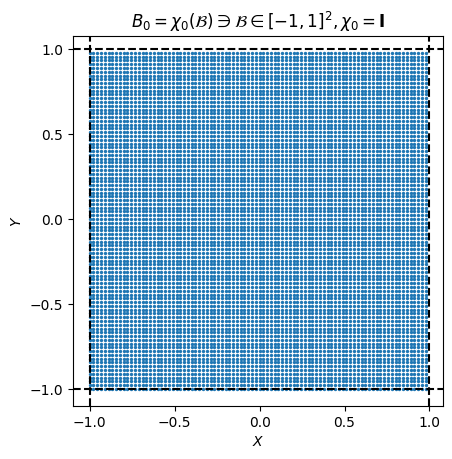

In [5]:
plot_cm(
    x=X, y=Y, s=2,
    title=r'$B_0 = \chi_0(\mathcal{B}) \ni \mathcal{B} \in [-1, 1]^2, \chi_0 = \mathbf{I}$',
    xlabel=r'$X$', ylabel=r'$Y$',
)


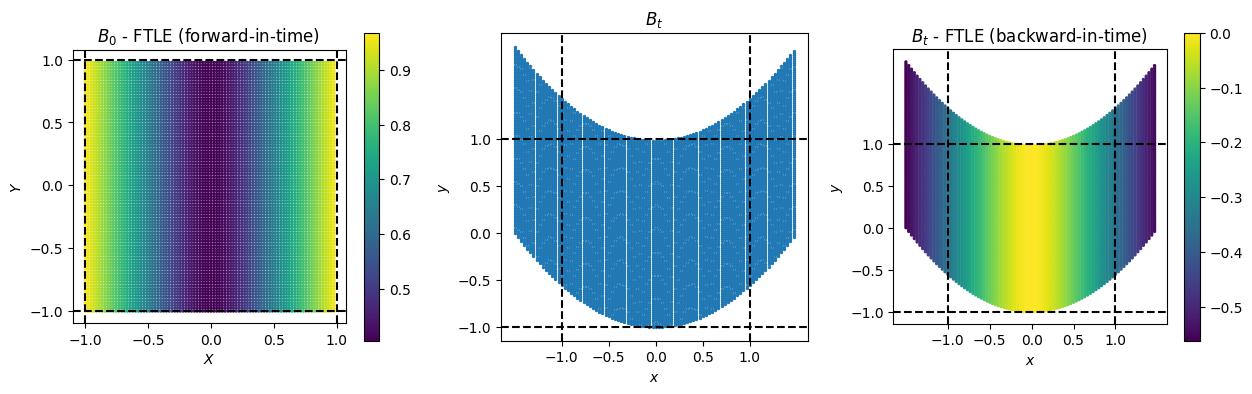

In [20]:
x, y, phi_title, c_fit, c_bit = flow_map(X, Y, 'parab', a=1.5, b=1)
# c_bit = -c_bit if c_bit is not None else None

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plot_cm(
    x=X, y=Y, s=2., c=c_fit,
    xlabel=r'$X$', ylabel=r'$Y$',
    title=r"$B_0$ - FTLE (forward-in-time) ",
)


plt.subplot(1, 3, 2)
# plot_cm(x=x, y=y, s=2., title=r'$B_t = \chi_t(\mathcal{B}) = %s \ni \varphi: B_0 \rightarrow B_t$' % phi_title)
plot_cm(
    x=x, y=y, s=2.,
    title=r"$B_t$"#r'$B_t = \chi_t(\mathcal{B}) = %s \ni \varphi: B_0 \rightarrow B_t$' % phi_title,
)

plt.subplot(1, 3, 3)
plot_cm(
    x=x, y=y, s=2., c=c_bit,
    title=r"$B_t$ - FTLE (backward-in-time) ",
)

### Test FTLE - PySPH

In [7]:
ftle_ob = FTLyapunovExponent.from_example(dim=2, nx=40, flow_type='parabolic')
# Time forward
t0 = time.time()
ftle_fit_res = ftle_ob.compute(ftle_type='forward', mode='mpi')
t1 = time.time()
print(f"Computed forward FTLE in {t1-t0} seconds")

mode = 'mpi'
Computed forward FTLE in 21.33698010444641 seconds


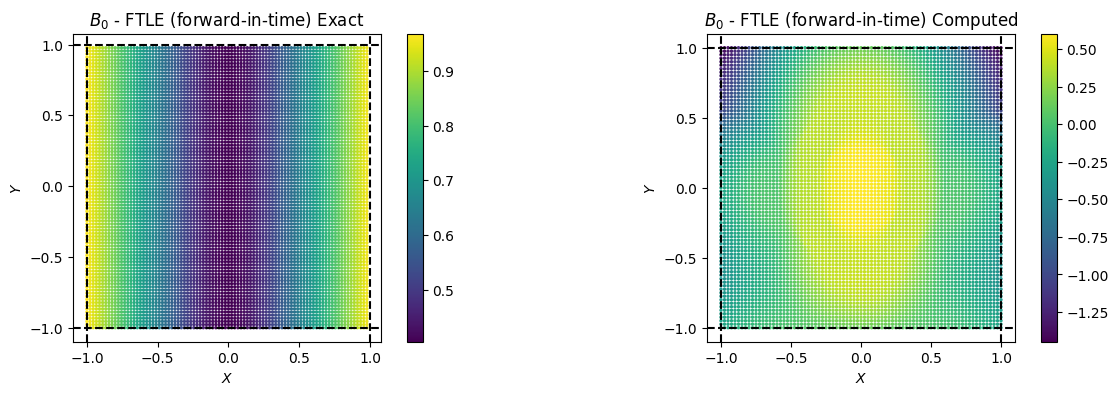

In [21]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plot_cm(
    x=X, y=Y, s=2., c=c_fit,
    xlabel=r'$X$', ylabel=r'$Y$',
    title=r"$B_0$ - FTLE (forward-in-time) Exact",
)

plt.subplot(1, 2, 2)
X_comp = ftle_ob.pa_0.get('x')
Y_comp = ftle_ob.pa_0.get('y')
c_fit_comp = ftle_fit_res
plot_cm(
    x=X_comp, y=Y_comp, c=c_fit_comp, s=2,
    xlabel=r'$X$', ylabel=r'$Y$',
    title=r"$B_0$ - FTLE (forward-in-time) Computed",
)

In [9]:
t0 = time.time()
ftle_bit_res = ftle_ob.compute(ftle_type='backward', mode="mpi")
t1 = time.time()
print(f"Computed backward FTLE in {t1-t0} seconds")

mode = 'mpi'
Computed backward FTLE in 21.31906771659851 seconds


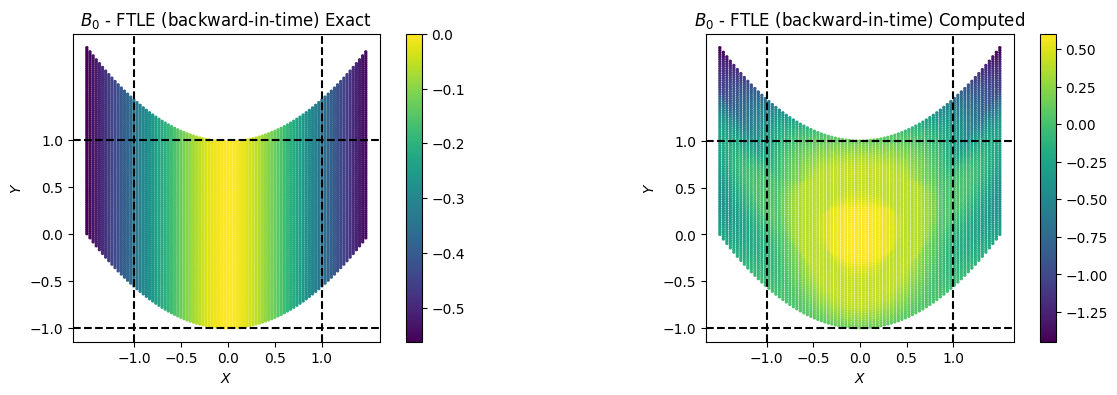

In [22]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plot_cm(
    x=x, y=y, s=2., c=c_bit,
    xlabel=r'$X$', ylabel=r'$Y$',
    title=r"$B_0$ - FTLE (backward-in-time) Exact",
)

plt.subplot(1, 2, 2)
x_comp = ftle_ob.pa_f.get('x')
y_comp = ftle_ob.pa_f.get('y')
c_bit_comp = ftle_fit_res
plot_cm(
    x=x_comp, y=y_comp, c=c_bit_comp, s=2,
    xlabel=r'$X$', ylabel=r'$Y$',
    title=r"$B_0$ - FTLE (backward-in-time) Computed",
)

### Matrix Multiplication

In [11]:
import numpy as np

In [12]:
# Create a 3X3 array from 0 to 8
a = np.arange(4).reshape(2,2)
a = np.arange(9).reshape(3,3)
a_flat = a.flatten()
a_flat, a

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]]))

In [13]:
# Multiply a transpose of a with a
b_expected = np.dot(a.T, a)
a.T, a, b_expected

(array([[0, 3, 6],
        [1, 4, 7],
        [2, 5, 8]]),
 array([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]]),
 array([[45, 54, 63],
        [54, 66, 78],
        [63, 78, 93]]))

In [14]:
# Multiply transpose of a with a and store in b
b_flat = np.zeros(9)
for i in range(3):
    for j in range(3):
        b_flat[3*i + j] = 0.
        for k in range(3):
            b_flat[3*i + j] += a_flat[3*k + i] * a_flat[3*k + j]

In [15]:
print(b_flat.reshape(3,3))

[[45. 54. 63.]
 [54. 66. 78.]
 [63. 78. 93.]]


### Eigen Values

In [16]:
import numpy as np
from pysph.base import linalg3

In [17]:
a = np.ones((3,3), dtype=float)
a = np.diag((2., 2., 1.))
a = np.arange(9, dtype=np.float64).reshape(3,3)

# Generate rabdom positive definite matrix
dim = 2
a = np.random.rand(dim, dim)
a = np.dot(a, a.T)

print(f"{a = }")
eigs_np = np.linalg.eigvals(a)
if dim == 2:
    # Append zero eigenvalue
    eigs_np = np.append(eigs_np, 0.)
eigs_np = np.sort(eigs_np)
print(f"{eigs_np = }")

# Add zero row and column
if dim  == 2:
    a = np.pad(a, ((0, 1), (0, 1)), 'constant', constant_values=0.)
# print(f"{a = }")
# # raise SystemExit

eigs_pysph = linalg3.py_get_eigenvalues(a)
eigs_pysph.sort()
print(f"{eigs_pysph = }")


err = np.max(np.abs(eigs_np - eigs_pysph))
print(f"{err = }")


a = array([[0.52483715, 0.13456106],
       [0.13456106, 0.0391822 ]])
eigs_np = array([0.        , 0.00439148, 0.55962787])
eigs_pysph = array([1.66533454e-16, 4.39148283e-03, 5.59627869e-01])
err = 1.6653345369377348e-16


In [18]:
%timeit np.sort(np.linalg.eigvals(a))

26.3 µs ± 824 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [19]:
%timeit linalg3.py_get_eigenvalues(a).sort()

1.88 µs ± 119 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
